In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
agg_dataset = pd.read_csv('./data/agg_dataset.csv')

## Skewness and Outliers

### Numerical features

Let's start by numeric values. We will first analyze their correlations after all the transformations the dataset went through.

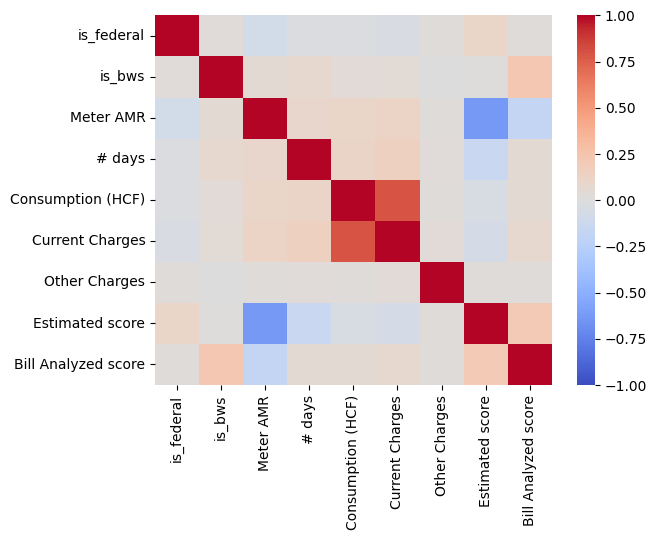

In [3]:
sns.heatmap(data=agg_dataset.corr(numeric_only=True).round(3), cmap='coolwarm', vmin=-1, vmax=1);

Some features are highly correlated. This could harm clustering performances. Dimensionality reduction algorithm that projects the instances in an uncorrelated spaces, like PCA for example, are required before any type of clustering.

*Note: # BWS has been transformed into boolean from Rate Class. Now it counts the number of and its contribution it's practically the same of time read. The feature were really skewed and so it will be removed.*

In [4]:
agg_dataset.describe()

,# days,Consumption (HCF),Current Charges,Other Charges,Estimated score,Bill Analyzed score
count,742.000000,742.000000,7.420000e+02,742.000000,742.000000,742.000000
mean,1559.808625,10911.955526,9.901344e+04,398.204030,0.235793,0.972924
std,903.998211,25983.218621,1.873239e+05,4795.235233,0.377788,0.034636
min,6.000000,0.000000,0.000000e+00,0.000000,0.000000,0.500000
25%,770.750000,336.250000,3.716445e+03,0.000000,0.000000,0.956753
50%,1560.500000,2441.500000,2.158471e+04,0.000000,0.000000,0.976744
75%,2656.000000,11929.500000,1.160602e+05,0.000000,0.379627,1.000000
max,4057.000000,487833.000000,1.713234e+06,108034.240000,1.000000,1.000000


Let's better look, graphically, the correlation. Using scatter matrix, we will have an idea on the distributions of those features.

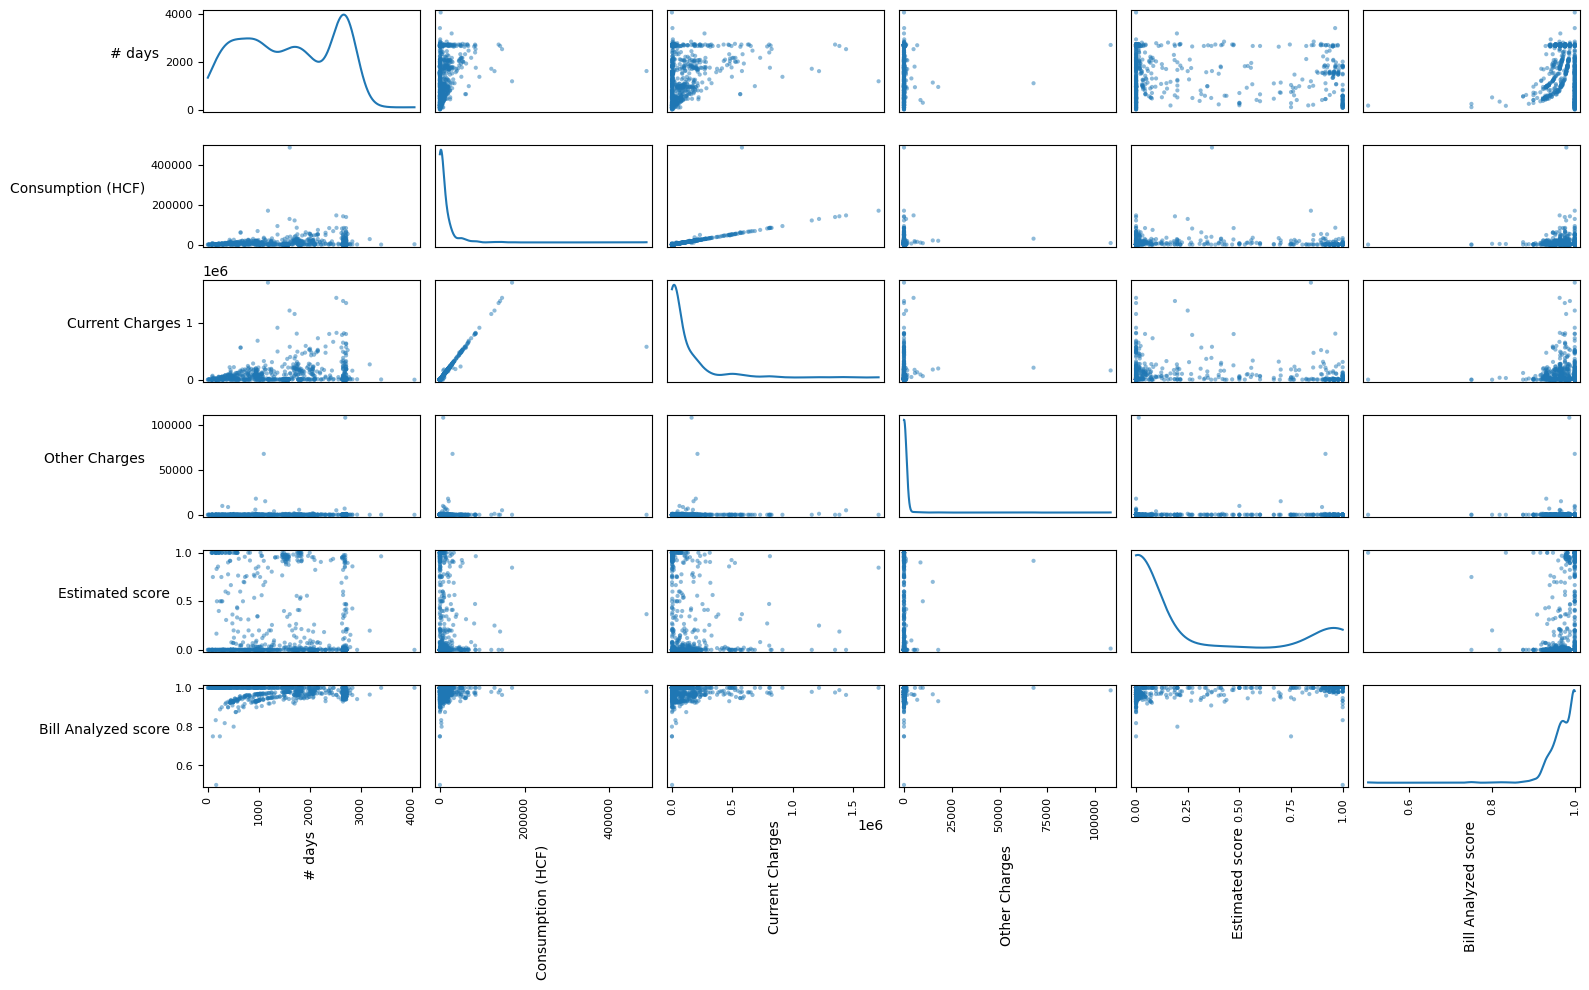

In [5]:
scatter_matrix = pd.plotting.scatter_matrix(
    agg_dataset.select_dtypes(include='number'), 
    figsize=(16, 10),
    diagonal='kde'
)

for ax in scatter_matrix.flatten(): 
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

diagonal = scatter_matrix.diagonal()

plt.tight_layout()
plt.show()

- Standardization on the heavy tailed features may be required;
- A careful management of multimodal distributions like bill_analyzed and #_days is required. I'll try using GMM.

We can now approach categorical features on the transformed dataset. The goal here is to decide the encoding type.

In [6]:
agg_dataset.select_dtypes(include='string').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Empty DataFrame


### Boroughs

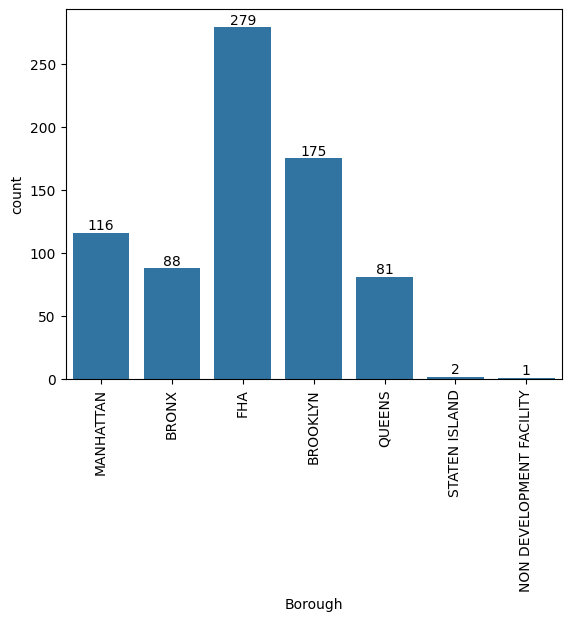

In [7]:
ax = sns.countplot(data=agg_dataset, x='Borough').axes
ax.bar_label(ax.containers[0])
ax.tick_params('x', rotation=90)

- It's straightforward to see that some categories are severly underepresented; 
- In this case their frequency can be meaningful;
- *Count encoding will be used*.

### Account Name and Building

These are high cardinality features. The solution i'll adopt is to extract other features from them, that could be far more useful than hundreads of categories with very low significance. 
- From building it will be extracted the type of the location;
- From account name it will be extracted additional informations on the development in which buildings lie.

In [8]:
building_counts = agg_dataset['Building'].value_counts().reset_index()
building_counts.head()

,Building,count
0,305_BLD 01,10
1,2_BLD 08,8
2,222_BLD 02-03,5
3,343_BLD 01,5
4,123_BLD 05,4


By watching the data from the data wrangler it looks like that a building could be placed on, or near:
- STREET
- AVENUE
- PLACE
- COMMUNITY CENTER
- BOULEVARD
- ROAD
- UNSPECIFIED (generic building)

In [9]:
account_counts = agg_dataset['Account Name'].value_counts().reset_index()
account_counts.head()

,Account Name,count
0,SAMUEL (CITY),54
1,FHA REPOSSESSED HOUSES (GROUP V),53
2,FHA REPOSSESSED HOUSES (GROUP I),41
3,FHA REPOSSESSED HOUSES (GROUP X),37
4,SOUTH JAMAICA II,33


In this case there are two main categories for developments: 
- FHA REPOSSESSED HOUSES
- REHAB
- OTHER (in this category will fall every other development) 

### Recover true borough

In [10]:
account_counts[account_counts['Account Name'].str.match(pat=r'.*FHA.*')]

,Account Name,count
1,FHA REPOSSESSED HOUSES (GROUP V),53
2,FHA REPOSSESSED HOUSES (GROUP I),41
3,FHA REPOSSESSED HOUSES (GROUP X),37
5,FHA REPOSSESSED HOUSES (GROUP II),27
7,FHA REPOSSESSED HOUSES (GROUP IV),24
8,FHA REPOSSESSED HOUSES (GROUP III),22
11,FHA REPOSSESSED HOUSES (GROUP IX),19
12,FHA REPOSSESSED HOUSES (GROUP VII),17
13,FHA REPOSSESSED HOUSES (GROUP VI),15
15,FHA REPOSSESSED HOUSES (GROUP VIII),14


Let's read [development data book](https://www.nyc.gov/assets/nycha/downloads/pdf/pdb2020.pdf) of 2020. By searching FHA we have a quick list at page 130, of all of these FHA repossed houses. All of these repossesed house are under the administration of "baisley park". Let's see if there exsit in the dataset an information about this account.

In [11]:
agg_dataset[agg_dataset['Account Name'] == 'BAISLEY PARK']['Borough'].unique()

array(['QUEENS'], dtype=object)

Here is the answer. Every borough that corresponds to FHA should be mapped to QUEENS. The situation is confirmed buy pmoi.pdf inside data folder.
- We can effectively use account name to extract the development category without redundancies with boroughs.

### Operations application

Before looking for outliers, let'apply these transformations. 

*Note: same operations will be repeated in order to feet the pipeline in the preprocess file*.

In [12]:
agg_dataset['Account Name'] = agg_dataset['Account Name'] \
                                    .map(
                                        lambda x: 
                                            'FHA' if 'FHA' in x else 
                                            'REHAB' if 'REHAB' in x else 
                                            'UNSPECIFIED_CATEGORY' # default
                                    )

agg_dataset['Account Name'].value_counts()

Account Name
UNSPECIFIED_CATEGORY    371
FHA                     279
REHAB                    92
Name: count, dtype: int64

In [13]:
agg_dataset['Building'] = agg_dataset['Building'] \
                            .map(
                                lambda x: 
                                    'STREET' if 'STREET' in x else 
                                    'AVENUE' if 'AVENUE' in x else
                                    'PLACE' if 'PLACE' in x else 
                                    'COMMUNITY CENTER' if 'Community Center' in x else
                                    'BOULEVARD' if 'BOULEVARD' in x else
                                    'ROAD' if 'ROAD' in x else 
                                    'UNSPECIFIED_TYPE' # default
                            )

agg_dataset['Building'].value_counts()

Building
UNSPECIFIED_TYPE    467
STREET              140
AVENUE               73
BOULEVARD            21
PLACE                16
COMMUNITY CENTER     13
ROAD                 12
Name: count, dtype: int64

In [14]:
agg_dataset['Borough'] = agg_dataset['Borough'].map(lambda x: 'QUEENS' if x == 'FHA' else x)

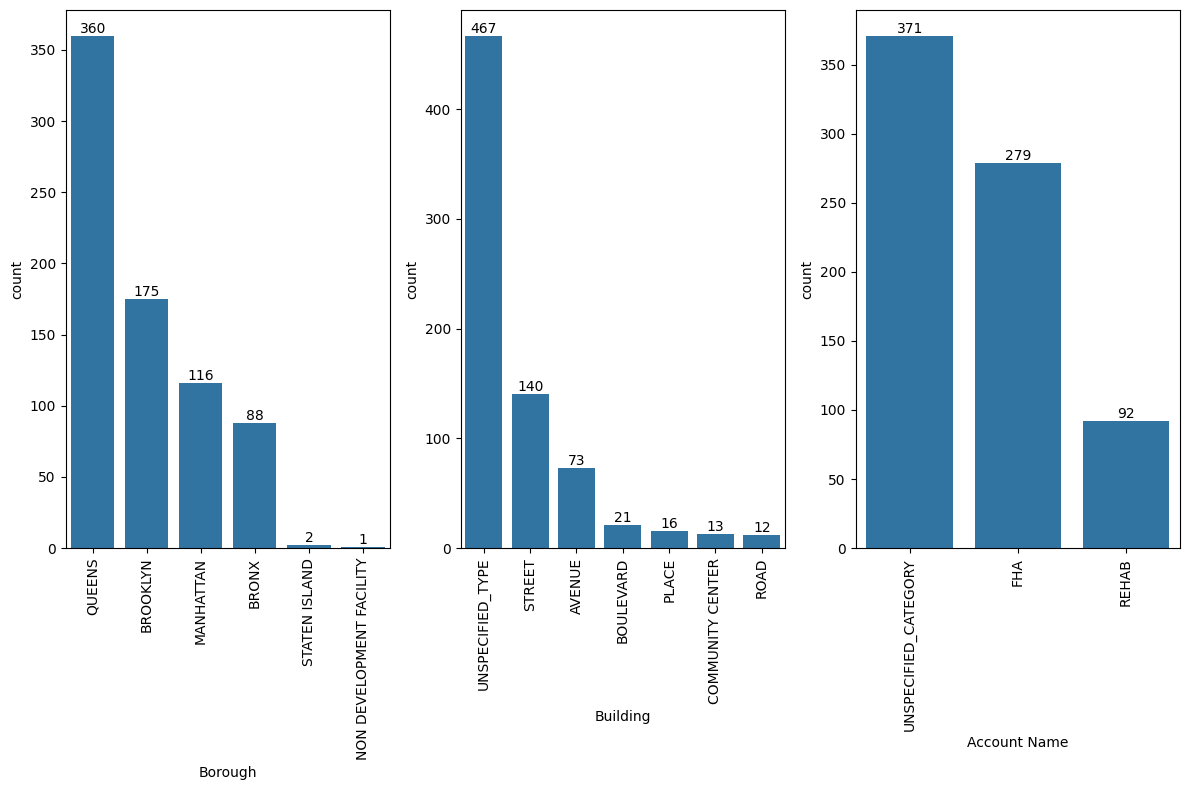

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 8))

ax_borough = sns.countplot(data=agg_dataset, x='Borough', ax=axes[0], order=agg_dataset['Borough'].value_counts().index)
ax_borough.bar_label(ax_borough.containers[0])
ax_borough.tick_params('x', rotation=90)

ax_location_type = sns.countplot(data=agg_dataset, x='Building', ax=axes[1], order=agg_dataset['Building'].value_counts().index)
ax_location_type.bar_label(ax_location_type.containers[0])
ax_location_type.tick_params('x', rotation=90)

ax_dev_cat = sns.countplot(data=agg_dataset, x='Account Name', ax=axes[2], order=agg_dataset['Account Name'].value_counts().index)
ax_dev_cat.bar_label(ax_dev_cat.containers[0])
ax_dev_cat.tick_params('x', rotation=90)

plt.tight_layout()